# Importing the libraries

In [1]:
# Extracting the dataset from the .zip file
from os import walk
import zipfile

# Get the execution times
import time

# Work with the dataset
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# Work with the machine learning models
import numpy as np

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, GridSearchCV

# Setting default values

Setting some default values to be used all over the code.

The values below could be changed if you are experiencing problems of performance or memory problems.

In [2]:
### TODO: define more standard values to be used by the code (cv, n_jobs, scoring, limit df)

# Used to fill the random state of some functions
SEED = 50

# The number of samples to be used during the machine learning model training
N_SAMPLES = 10**4

# Limits the number of values of the inital dataframe
# A value of less than 1 means to get all the dataset
DF_LIMIT = N_SAMPLES*10

# Extracting and loading the dataset

In [3]:
# Find the .zip file and get the path to extract it
dataset_folder = './dataset'
    
filenames = next(walk(dataset_folder), (_, _, []))[2]
zip_filename = [filename for filename in filenames if filename.find('.zip') > -1][0]
file_path = dataset_folder + '/' + zip_filename

You only need to run the code cell below if you put solely the .zip file insede the dataset folder.

In [4]:
# Extracting the contents of the .zip file inside the dataset folder
# Extract the file only if there isn't the .txt file inside the folder already
has_txt_dataset = np.sum([True for filename in filenames if filename.find('.txt') > -1]) > 0

if not has_txt_dataset:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

In [5]:
# Get the .txt dataset file path extracted at the previous step
filenames = next(walk(dataset_folder), (_, _, []))[2]
dataset_filename = [filename for filename in filenames if filename.find('.txt') > -1][0]
dataset_path = dataset_folder + '/' + dataset_filename

To load the dataset inside a Pandas DataFrame we had to put the delimiter to be a TAB (\t) because it is how the data is separated inside the .txt file.

In [6]:
df = pd.read_csv(dataset_path, delimiter = "\t")

The cell below gets a subset of rows from the original dataset to make it easier to work with the data.

It had to get the subset sequentially because the dataset is organized in a time based way and we need to respect this to make some transformations later on the dataframe.

In [7]:
if DF_LIMIT > 0:
    df = df[:DF_LIMIT]

# Analyzing the dataset

In [8]:
df.shape

(100000, 57)

In [9]:
df.head()

,Row,Sample Name,Transaction Id,Anon Student Id,Session Id,Time,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,...,KC (MCAS5-State_WPI-Simple),KC Category (MCAS5-State_WPI-Simple),KC (MCAS5-State_WPI-Simple).1,KC Category (MCAS5-State_WPI-Simple).1,KC (Single-KC),KC Category (Single-KC),KC (Unique-step),KC Category (Unique-step),School,Class
0,1,All Data,13cb29890fa2be0ca31bcd07f35000d6,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:10,US/Eastern,22,ATTEMPT,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
1,2,All Data,3fedf6c06ab6b9b3c36e245335445bcf,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:13,US/Eastern,3,HINT_REQUEST,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
2,3,All Data,0f5bb1a5c133ac1aa0a3d32e4d44dde9,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:20,US/Eastern,7,HINT_REQUEST,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
3,4,All Data,19a9aabf614d6f27dc9970dc842da081,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:22,US/Eastern,2,HINT_REQUEST,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy
4,5,All Data,eae2bd81fd19ec6093c645d90e92222e,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2006-10-13 11:53:32,US/Eastern,10,ATTEMPT,NaN,...,NaN,NaN,NaN,NaN,Single-KC,NaN,NaN,NaN,ForestGrove,Period40607Dumphy


In [10]:
df.dtypes

Row                                          int64
Sample Name                                 object
Transaction Id                              object
Anon Student Id                             object
Session Id                                   int64
Time                                        object
Time Zone                                   object
Duration (sec)                              object
Student Response Type                       object
Student Response Subtype                   float64
Tutor Response Type                         object
Tutor Response Subtype                     float64
Level (Curriculum)                          object
Problem Name                                 int64
Problem View                               float64
Problem Start Time                          object
Step Name                                   object
Attempt At Step                            float64
Is Last Attempt                            float64
Outcome                        

In [11]:
df.describe()

,Row,Session Id,Student Response Subtype,Tutor Response Subtype,Problem Name,Problem View,Attempt At Step,Is Last Attempt,Help Level,Total Num Hints,...,KC Category (WPI-Apr-2005).4,KC Category (WPI-Apr-2005).5,KC Category (MCAS39-State_WPI-Simple),KC Category (MCAS39-State_WPI-Simple).1,KC Category (MCAS39-State_WPI-Simple).2,KC Category (MCAS39-State_WPI-Simple).3,KC Category (MCAS5-State_WPI-Simple),KC Category (MCAS5-State_WPI-Simple).1,KC Category (Single-KC),KC Category (Unique-step)
count,100000.000000,1.000000e+05,0.0,0.0,100000.000000,99977.000000,99885.000000,99885.000000,25770.000000,19758.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,50000.500000,4.479398e+06,NaN,NaN,5697.734560,1.273503,2.363168,0.451359,2.033333,3.542970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,28867.657797,2.772223e+06,NaN,NaN,5163.535758,0.658922,2.611667,0.497631,1.611934,1.321847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.450000e+03,NaN,NaN,7.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,25000.750000,1.393139e+06,NaN,NaN,1158.000000,1.000000,1.000000,0.000000,1.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,50000.500000,5.531069e+06,NaN,NaN,3140.000000,1.000000,1.000000,0.000000,2.000000,3.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,75000.250000,6.878193e+06,NaN,NaN,9929.000000,1.000000,3.000000,1.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,100000.000000,8.165983e+06,NaN,NaN,17959.000000,11.000000,63.000000,1.000000,39.000000,39.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.nunique()

Row                                        100000
Sample Name                                     1
Transaction Id                             100000
Anon Student Id                               328
Session Id                                  27807
Time                                        97052
Time Zone                                       1
Duration (sec)                                551
Student Response Type                           2
Student Response Subtype                        0
Tutor Response Type                             2
Tutor Response Subtype                          0
Level (Curriculum)                              1
Problem Name                                 1426
Problem View                                   10
Problem Start Time                          27168
Step Name                                    3686
Attempt At Step                                63
Is Last Attempt                                 2
Outcome                                         3


Each row of the dataset represents an interaction an user has with an intelligent tutoring system.

The students are divided between schools and classes.

As we can see there are some columns that probably will not be very useful for most of the analysis.

Some columns contains no unique values, so they are candidate to be dropped. Other ones have an exclusive value per row, not contributing with the analysis.

# Data preprocessing

The criteria used to drop the columns were:
- Columns with one or less unique values in it.
- Columns with all rows with unique values.
- KC columns (KCs are Knowledge Components, created using the system provided by DataShop system, where we got the data).
- Columns with high quantity of unique values (probably they will overfit the machine learning model).

In [13]:
def drop_unnecessary_columns(df):
    """ Drop unnecessary columns from a dataframe to be used during the analysis
    The criteria used to drop the columns are:
        - 1 o less unique values per column;
        - All rows containing unique values;
        - Columns that represent the KC;
        - Columns with a high quantity of unique values.
        
    Arguments:
        - df (pandas DataFrame): The dataframe containing the columns to be dropped.
        
    Returns:
        - df_cleaned (pandas DataFrame): A copy of the input dataframe with the columns dropped.
    """
    
    unique_values = df.nunique()
    
    # Dropping the columns with 0 or 1 exclusive values
    df_cleaned = df.loc[:, (unique_values > 1)]
    
    # Dropping the columns with an unique value per row
    df_cleaned = df_cleaned.loc[:, (unique_values < df_cleaned.shape[0])]
    
    # Dropping the KC columns
    df_cleaned = df_cleaned.loc[:, [col.find('KC (') < 0 for col in df_cleaned.columns]]
    
    # Dropping columns with high variability values
    # At this part only the "Time" and "Problem Start Time" were dropped
    # I will not drop the Session Id column because I want to use it at the Machine Learning code
    columns_to_drop = [k for k,v in df_cleaned.nunique().items() if ((v / df_cleaned.shape[0]) > 0.2) and (k != 'Session Id')]
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)
    
    return df_cleaned

In [14]:
def adjust_data_types(df):
    """ Adjust the data types of columns classified as object or float to float and integer respectively.
        
    Arguments:
        - df (pandas DataFrame): The dataframe containing the columns to be adjusted.
        
    Returns:
        - df_new (pandas DataFrame): A copy of the input dataframe with the columns' types adjusted.
    """
    
    df_new = df.copy()
    
    # Converting the "Duration (sec)" values from object to float
    # It had to be converted to float because it has some decimal values at some rows
    # We had to replace the dot (.) values to convert the values to float
    df_new['Duration (sec)'] = df_new['Duration (sec)'].replace('.', '0', regex=False).astype('float64')

    # Converting some float columns to int to reduce the range of allowed values in these columns
    # They don't need to use decimal points for theirs values
    # I had to use the Int64 type (Pandas integer) instead of int64 type (Numpy integer) because the existent NaN values that could not be converted
    float_to_int_columns = ['Problem View', 'Attempt At Step', 'Is Last Attempt', 'Help Level', 'Total Num Hints']

    df_new[float_to_int_columns] = df_new[float_to_int_columns].astype('Int64')
    
    return df_new

In [15]:
df_cleaned = drop_unnecessary_columns(df)
df_cleaned = adjust_data_types(df_cleaned)

In [16]:
df_cleaned.head()

,Anon Student Id,Session Id,Duration (sec),Student Response Type,Tutor Response Type,Problem Name,Problem View,Step Name,Attempt At Step,Is Last Attempt,Outcome,Selection,Action,Input,Feedback Text,Feedback Classification,Help Level,Total Num Hints,School,Class
0,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,22.0,ATTEMPT,RESULT,10168,1,Step0:10168:There are 100 squares in the 10 by...,1,0,INCORRECT,Step0:10168:There are 100 squares in the 10 by...,1,80/100,Don't forget to reduce your fraction.,NaN,<NA>,<NA>,ForestGrove,Period40607Dumphy
1,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,3.0,HINT_REQUEST,HINT_MSG,10168,1,Step0:10168:There are 100 squares in the 10 by...,2,0,HINT,Step0:10168:There are 100 squares in the 10 by...,1,NaN,There are 100 squares and 80 are colored purple.,HINT,1,<NA>,ForestGrove,Period40607Dumphy
2,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,7.0,HINT_REQUEST,HINT_MSG,10168,1,Step0:10168:There are 100 squares in the 10 by...,3,0,HINT,Step0:10168:There are 100 squares in the 10 by...,1,NaN,80/100 squares are colored purple. Reduce this...,HINT,2,<NA>,ForestGrove,Period40607Dumphy
3,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,2.0,HINT_REQUEST,HINT_MSG,10168,1,Step0:10168:There are 100 squares in the 10 by...,4,0,HINT,Step0:10168:There are 100 squares in the 10 by...,1,NaN,80/100 = 8/10 = 4/5,HINT,3,<NA>,ForestGrove,Period40607Dumphy
4,Stu_000271be877ea1e7bf4f038c96cee5f9,5660580,10.0,ATTEMPT,RESULT,10168,1,Step0:10168:There are 100 squares in the 10 by...,5,1,CORRECT,Step0:10168:There are 100 squares in the 10 by...,1,4/5,NaN,NaN,<NA>,<NA>,ForestGrove,Period40607Dumphy


## Checking the differences between some columns

Some columns apparently have similar values or similar information.

Below we analyzed the differences between the *Step Name* and the *Selection* columns. Apparently they have the same values for each row, so it would be wiser to drop one of them. The only difference we found between then is that the *Step Name* column has aditional text at the end of it, probably because some misconfiguration of the input dataset.

The other ones that have similar information are the *Help Level* and the *Total Num Hints* columns. But the *Total Num Hints* only stores the maximum value of the *Help Level* grouped by *Session*, *Problem Name* and *Step Name*.

**_Step Name_ and _Selection_ columns**

In [17]:
# Creating a test DataFrame with only the rows that have explicitly different values on which column
df_test_step_selection = df_cleaned[df_cleaned['Step Name'] != df_cleaned['Selection']][['Step Name', 'Selection']]
df_test_step_selection = df_test_step_selection.reset_index()

In [18]:
idx = 0

print('Values at index {} without reduncing the length of the "Step Name" column.'.format(idx))
print(df_test_step_selection['Step Name'][idx])
print(df_test_step_selection['Selection'][idx])

selection_len = len(df_test_step_selection['Selection'][idx])

print()
print('Values at index {} reduncing the length of the "Step Name" column.'.format(idx))
print(df_test_step_selection['Step Name'][idx][:selection_len])
print(df_test_step_selection['Selection'][idx])

Values at index 0 without reduncing the length of the "Step Name" column.
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction) 1
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction)

Values at index 0 reduncing the length of the "Step Name" column.
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction)
Step0:10168:There are 100 squares in the 10 by 10 grid above. What fraction of the squares are colored purple? (Make sure you reduce the fraction)


In [19]:
total_diff = 0
total_nan = 0

for i in range(df_test_step_selection.shape[0]):
    selection_len = len(df_test_step_selection['Selection'][i])
    
    step = df_test_step_selection['Step Name'][i]
    
    if type(step) == str:
        step = step[:selection_len]
    else:
        total_nan += 1
    
    if step != df_test_step_selection['Selection'][i]:
        total_diff += 1

print('Calculated differences between columns when the length of the "Step Name" column is reduced to match the "Selection" column.')
print('Total of different values: {}'.format(total_diff))
print('Total of different values with at leat one NaN: {}'.format(total_nan))
print('Total of different values without the NaNs: {}'.format(total_diff - total_nan))

Calculated differences between columns when the length of the "Step Name" column is reduced to match the "Selection" column.
Total of different values: 267
Total of different values with at leat one NaN: 115
Total of different values without the NaNs: 152


In [20]:
pct_diff = (total_diff - total_nan) / df_cleaned.shape[0]

print('There is only {:.4f}% of different values between the "Step Name" and the "Selection" columns.'.format(pct_diff))

There is only 0.0015% of different values between the "Step Name" and the "Selection" columns.


There are so few values that the differences are not relevant

In [21]:
df_cleaned = df_cleaned.drop(columns=['Selection'])

**_Help Level_ and _Total Num Hints_ columns**

In [22]:
# Getting only the rows where the "Total Num Hints" column has some value
df_test_hints = df_cleaned[df_cleaned['Total Num Hints'] >= 0]

df_test_hints = df_test_hints[df_test_hints['Total Num Hints'] != df_test_hints['Help Level']]

df_test_hints[['Session Id', 'Problem Name', 'Step Name', 'Outcome', 'Help Level', 'Total Num Hints']].head(10)

,Session Id,Problem Name,Step Name,Outcome,Help Level,Total Num Hints
29,5661544,3738,Step1:3739:What is the difference between the ...,HINT,1,3
30,5661544,3738,Step1:3739:What is the difference between the ...,HINT,2,3
33,5661544,3738,"Step2:3740:Well done. Now, what is the differe...",HINT,1,3
34,5661544,3738,"Step2:3740:Well done. Now, what is the differe...",HINT,2,3
37,5661544,3738,"Step3:3741:Good. So, we see that the salary go...",HINT,1,2
41,5661544,3738,Step4:3742:Good. Now what is the salary of an ...,HINT,1,4
42,5661544,3738,Step4:3742:Good. Now what is the salary of an ...,HINT,2,4
43,5661544,3738,Step4:3742:Good. Now what is the salary of an ...,HINT,3,4
47,5662026,8135,Step1:8136:Every factor has a partner because ...,HINT,1,2
51,5662026,8135,"Step2:8137:130 divided by 2 is 65, so the fact...",HINT,1,6


In [23]:
print('Total of different values between columns: {}'.format(df_test_hints.shape[0]))

Total of different values between columns: 13913


## Enhancing the dataset

At this part we tried to create some new columns to be used during the training of the predictive model.

Columns created:
- Last Help Level: indicating what was the last value of the column *Help Level* before CORRECT or INCORRECT value at the *Outcome* column.

**Last Help Level**

We can get the Last Help Level grouping the *Session Id*, *Problem Name* and *Step Name* columns.

We have to group by these columns because after that, the Help Level returns to the value of 0.

We have to fill the remaing NaN values with 0 because, sometimes the grouping doesn't start with the outcoume of a HINT, causing the Help Value to be a NaN.

In [24]:
# Based on https://stackoverflow.com/questions/44111425/cannot-use-fillna-when-a-condition-is-introduced

# This step could take a while
group_columns = ['Session Id', 'Problem Name', 'Step Name']

# Filling the next value based on the grouping
df_cleaned['Last Help Level'] = df_cleaned.groupby(group_columns)['Help Level'].fillna(method='ffill')

# Filling the initial value
df_cleaned['Last Help Level'] = df_cleaned['Last Help Level'].fillna(0)

# Data analysis

In [25]:
def plot_bar(data, title='Number of occurrences', xlabel='x', ylabel='Number of occurrences', rotation=90, show_xticks=True):
    """Plots a bar chart with some customizations
    
    Arguments:
        - data (pandas Series): A series containing the data to plot the chart
        - title (str): The title of the chart
        - xlabel (str): The label of the x axis of the chart
        - ylabel (str): The label of the y axis of the chart
        - rotation (int): The rotation angle of the values of the x axis
        - show_xticks (boolean): Definie if the chart has to show or not the values at xticks
    
    Returns:
        - None: Only plots the bar chart
    """
    
    x = data.keys()
    y = data.values
    
    plt.figure(figsize=(16, 6))

    plt.bar(x, y);
    
    plt.title(title);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.xticks(rotation=rotation);
    
    if not show_xticks:
        plt.xticks([])
    
    plt.show();

In [26]:
def print_statistics(data):
    """ Print some statistics based on the input data
        The printed statistics are:
            - The number of distinct values;
            - The mean;
            - The median;
            - The standard deviation.
    
    Arguments:
        - data (pandas Series): A series containing the data to plot the chart
        
    Returns:
        - None: Only print the statistics
    """
    
    print('Number of distinct values: {}'.format(len(data)))
    print('Mean: {:.2f}'.format(data.mean()))
    print('Median: {:.2f}'.format(data.median()))
    print('Standard Deviation: {:.2f}'.format(data.std()))

## Analyzing the number of interactions

**By School**

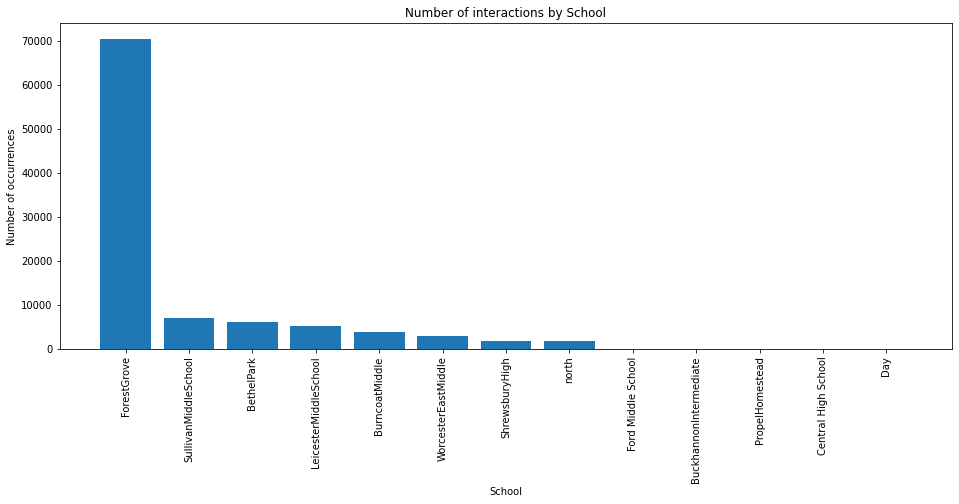

Number of distinct values: 13
Mean: 7689.38
Median: 1976.00
Standard Deviation: 19018.33


In [27]:
column = 'School'
data = df_cleaned[column].value_counts()
plot_bar(data, title='Number of interactions by {}'.format(column), xlabel=column)

print_statistics(data)

**By Class**

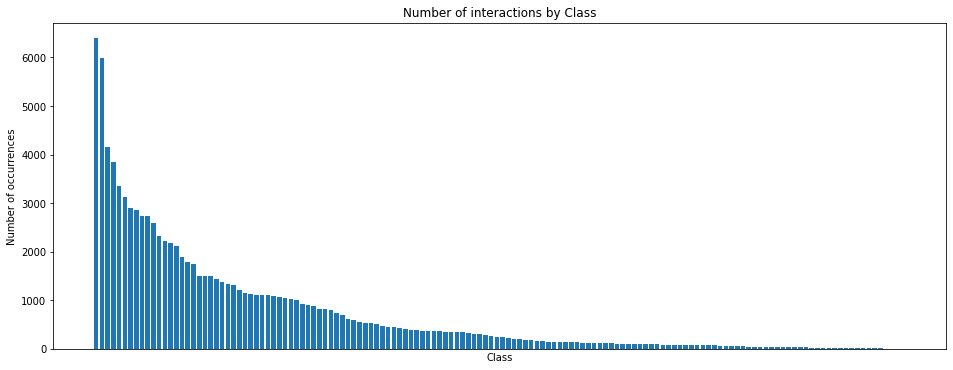

Number of distinct values: 142
Mean: 702.97
Median: 243.00
Standard Deviation: 1082.40


In [28]:
column = 'Class'
data = df_cleaned[column].value_counts()

# Hide the xticks because there is a lot of distinct values to show and the importance of this char is to show the distribution not the values by itself
plot_bar(data, title='Number of interactions by {}'.format(column), xlabel=column, show_xticks=False)

print_statistics(data)

**By Student**

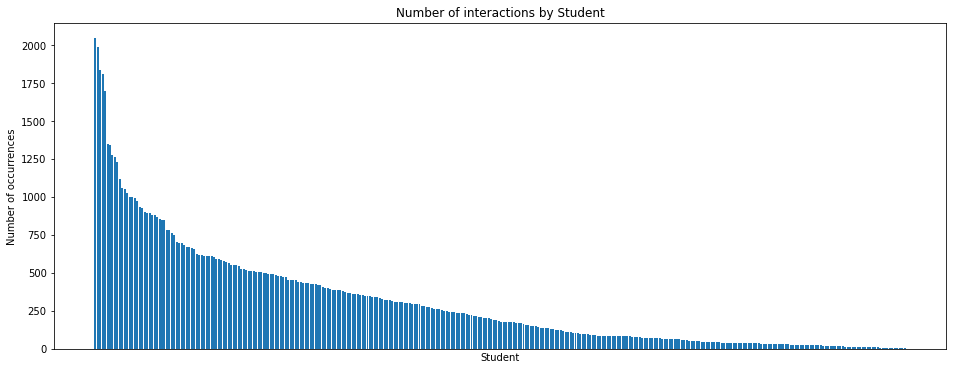

Number of distinct values: 328
Mean: 304.88
Median: 182.00
Standard Deviation: 349.04


In [29]:
column = 'Student'
data = df_cleaned['Anon ' + column + ' Id'].value_counts()

# Hide the xticks because there is a lot of distinct values to show and the importance of this char is to show the distribution not the values by itself
plot_bar(data, title='Number of interactions by {}'.format(column), xlabel=column, show_xticks=False)

print_statistics(data)

As we can see the number of interactions is not well distribuited, mostly comparing the distribution between schools where the ForestGrove school has a higher number of interactions. This could cause some bias at these analyses.

The interactions divided between classes and students follow the same pattern but with a lower standard deviation on data.

## Analyzing the number of students

**By School**

In [30]:
# Based on https://www.kite.com/python/answers/how-to-count-unique-values-in-a-pandas-dataframe-group-in-python

grouped_df = df_cleaned[['Anon Student Id', 'School']].groupby('School')
grouped_df = grouped_df.agg({'Anon Student Id': 'nunique'}).reset_index()

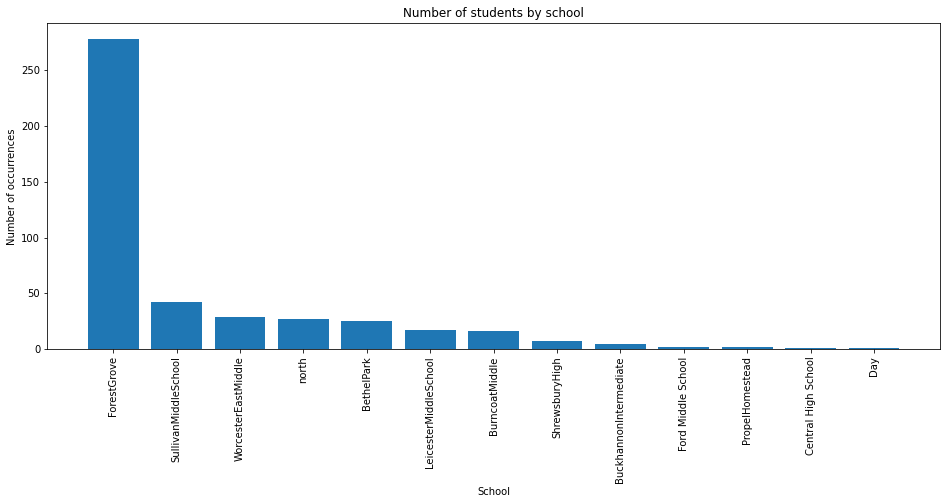

Number of distinct values: 13
Mean: 34.77
Median: 16.00
Standard Deviation: 74.25


In [31]:
data = pd.Series(grouped_df['Anon Student Id'].tolist(), index=grouped_df['School']).sort_values(ascending=False)
plot_bar(data, title='Number of students by school', xlabel='School')

print_statistics(data)

**Class**

In [32]:
grouped_df = df_cleaned[['Anon Student Id', 'School', 'Class']].groupby(['School', 'Class'])
grouped_df = grouped_df.agg({'Anon Student Id': 'nunique'}).reset_index()

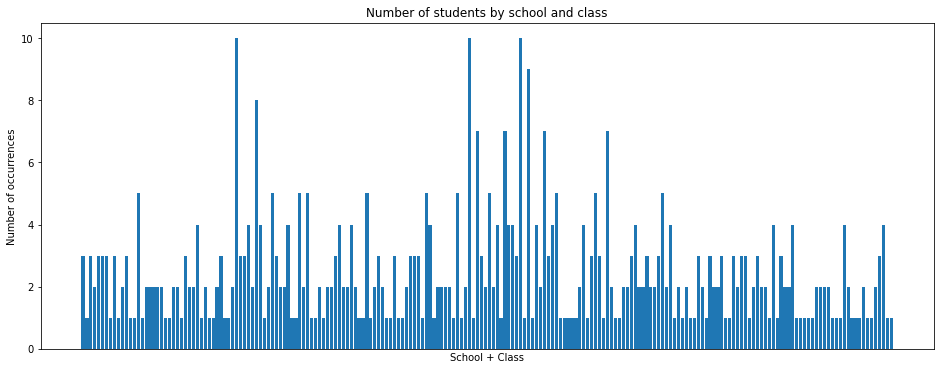

Number of distinct values: 206
Mean: 2.46
Median: 2.00
Standard Deviation: 1.73


In [33]:
data = grouped_df['Anon Student Id']
plot_bar(data, title='Number of students by school and class', xlabel='School + Class', show_xticks=False)

print_statistics(data)

The distribution of students between schools follow the same structure of the number of interactions, with a higher standard deviation and a big difference between the values of mean and median.

The number of students per class is well distributed with a few outiliers.

# Predictive model

At this part we tried to create a model that show us the best way to use the tutoring system to get the most of it.

We tried to predict when the students have a higher probability to input a right answer after receiving some hints.

The algorithms used were:
- MultinomialNB, as the baseline model to compare with the others;
- KNeighborsClassifier;
- DecisionTreeClassifier;
- GaussianNB;
- XGBClassifier;

We tried to use the SVC alogorithm but it was too slow to train so we discarded its use.

## Defining the metric

The choosed metrics to evaluate the models were:
- AUC (Area Under the Curve);
- F1-score;
- Accuracy;
- Fit time (how much time the algorithm spent fitting with the training data).

The AUC was defined as the main metric to be used. Its choice was based upon the fact that the AUC could generate a single number to determine how good a model is performing based on a variety of thresholds of the predicted probabilities of the classes.

F1-score was a metric used to analyze how well the generated model is going to run with a fixed threshold. It is based on the harmonic mean between the precision and recall metrics.

Accuracy and fit time were choosed as baseline metrics to help exclude some bad algorithms, so a algorithm with a low accuracy or a slow fit time could be a reason to discard the use of this algorithm.

If you want to understand these metrics better you could read this article: [Classification & Regression Evaluation Metrics](https://towardsdatascience.com/20-popular-machine-learning-metrics-part-1-classification-regression-evaluation-metrics-1ca3e282a2ce)

## Preparing the dataset for the model

Here we made some changes at the data to become an input to the machine learning models.

Only the CORRECT and INCORRECT outputs were considered at this analysis, because we considered that the HINT output could be considered as as intermediate level and its values were already used by the *Last Help Level* column.

We created a sample of the data to be easier to work with it and to have a less resource consumption.

Some functions were defined here to make the code more reusable on the next sections of the notebook.

In [34]:
ml_columns = ['Problem Name', 'Step Name', 'Attempt At Step', 'Outcome', 'Last Help Level']

def generate_samples(ml_columns, df_cleaned=df_cleaned):
    """ Generate sample data based on the default dataframe and 
    the columns defined in the parameters.
    
    The dataframe is filtered to get only the CORRECT and INCORRECT outcomes.
    
    The generated sample uses the bootstrapping effect.
    
    Arguments:
        - ml_columns (list): A list containing the columns to be retrieved from the dataset
        - df_cleaned (pandas DataFrame): The defult dataframe to be filtered and sampled
        
    Returns:
        - df_ml (pandas DataFrame): The sample dataframe
        - df_filtered (pandas DataFrame): The dataframe with all rows of the original but only
            with the CORRECT and INCORRECT outcomes and the inputted columns
    """

    df_filtered = df_cleaned[df_cleaned['Outcome'].isin(['CORRECT', 'INCORRECT'])][ml_columns]

    df_ml = df_filtered.sample(n=N_SAMPLES, replace=True, ignore_index=True, random_state=SEED)
    
    return df_ml, df_filtered

df_ml, df_filtered = generate_samples(ml_columns)

To generate the samples we used the parameter *replace=True* to get a bootstrapping effect from our data.

If you like to understand more you could read the Wikipedia page: [Bootstrapping_(statistics)](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))

In [35]:
df_filtered['Outcome'].value_counts() / df_filtered.shape[0]

CORRECT      0.585941
INCORRECT    0.414059
Name: Outcome, dtype: float64

In [36]:
df_ml['Outcome'].value_counts() / df_ml.shape[0]

CORRECT      0.5842
INCORRECT    0.4158
Name: Outcome, dtype: float64

The dristribution of the outputs is similar between the sample and the original dataset.

### Managing NaN values

As we can see below ther isn't any NaN values at the filtered dataframe created to generate the sample data, so we can conclude that each sample is going to have zero NaN values.

In [37]:
df_filtered.isnull().sum().sum()

0

### Creating dummy columns for the *Step Name* column

We had to create new columns for the categorical values of the *Step Name* column to pass the data to the algorithms.

In [38]:
def create_step_dummies(df):
    """ Create dummy columns from the categorical values of the Step Name column 
    to be used by the machine learning models.
    
    The Step Name column is also dropped, because it's not more necessary.
    
    Arguments:
        - df (pandas DataFrame): The dataframe that contains the Step Name column
        
    Returns:
        - df_ml (pandas DataFrame): The dataframe with the new columns and without the categorical values
    """
    
    df_ml = df.copy()

    ### This step is to get smaller names for the generated columns
    steps_names = df_ml['Step Name'].unique()

    dummy_columns_names = []

    for step_name in steps_names:
        idx = step_name.index(':', 7)
        dummy_columns_names.append(step_name[:idx])
        
    
    step_dummies = pd.get_dummies(df_ml['Step Name'])
    step_dummies.columns = dummy_columns_names
    
    
    df_ml = pd.concat([df_ml, step_dummies], axis=1)
    df_ml = df_ml.drop('Step Name', axis=1)
    
    return df_ml

In [39]:
df_ml = create_step_dummies(df_ml)

In [40]:
df_ml.head()

,Problem Name,Attempt At Step,Outcome,Last Help Level,Step0:13666,Step1:9189,Step4:5718,Step2:512,Step0:1291,Step0:8337,...,Step0:14088,Step0:17703,Step0:8806,Step6:5575,Step3:20348,Step0:12892,Step3:7425,Step1:14929,Step3:22646,Step0:8192
0,13666,5,CORRECT,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5790,1,INCORRECT,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106,2,INCORRECT,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,510,1,CORRECT,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1291,1,INCORRECT,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As you can see, now we have many more columns to input to the dataset.

### Changing some data types

Some machine learning models don't work well while using some data types like Int64 (pandas integer), so we had to change these types so the data could be used more universally between all the models.

We did too encode the column output, replacing the string values to integers to be equally used by the models.

In [41]:
def replace_dtypes(df):
    """ Change the data types of the Last Help Level and Attempt At Step columns to int64
    so that they could be more universally used by the machine learning models.
    
    The values from the Outcome column are encoded with 1 representing the CORRECT values
    and 0 representing the INCORRECT values.
    
    Arguments:
        - df (pandas DataFrame): The dataframe that contains the columns to have the data type changed
            and the Outcome column to be encoded
        
    Returns:
        - df_ml (pandas DataFrame): The dataframe with the new data types and the encoded Outcome column
    """
    
    df_ml = df.copy()

    df_ml['Last Help Level'] = df_ml['Last Help Level'].astype('int64')
    df_ml['Attempt At Step'] = df_ml['Attempt At Step'].astype('int64')
    
    df_ml['Outcome'] = df_ml['Outcome'].replace({'CORRECT': 1, 'INCORRECT': 0})
    
    return df_ml

In [42]:
df_ml = replace_dtypes(df_ml)

### Create train and test datasets

The labels we tried to predict come from the Outcome columns. The other columns from the dataframe were used as inputs to the machine learning algorithms.

Here we used the train_test_split function from the sklearn package to create the train and test datasets.

In [43]:
def train_test_create(df_ml):
    """ Get the X and Y to be used to train the machine learning models and to test the models
    with an unseen data.
    
    The Y values are based on the Outcome column. The other columns compose the X dataframe.
    
    Arguments:
        - df_ml (pandas DataFrame): The dataframe that contains the data to be used by 
            the machine learning algorithms
        
    Returns:
        - X_train (pandas DataFrame): The input dataframe to be used to train the machine learning models
        - X_test (pandas DataFrame): The input dataframe to be used to test the machine learning models
        - y_train (pandas Series): The output values to be predicted by the machine learning models during training
        - y_test (pandas Series): The output values to be predicted by the machine learning models during testing
    """
    
    X = df_ml.drop('Outcome', axis=1)
    y = df_ml['Outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
    
    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = train_test_create(df_ml)

## Creating the models

Here we started to work with the machine learning algorithms.

Some helper functions were created to make it easier to rerun the code without having to replicate the code.

During the process, metrics were collect to help to determine a good model to be used during the predictions.

We started creating a baseline model to help with the comparisons between model, after that the other algorithms were tested.

In [45]:
# Defining a dictionary to store the models' metrics
model_metrics = dict()

In [46]:
def get_metrics(y_test, y_pred, y_pred_prob):
    """ Get important metrics based on the parameters values and put then
    inside a python dictionary.
    
    The returned metrics are:
        - accuracy;
        - roc-auc;
        - f1-score.
    
    Arguments:
        - y_test (list): The list containing the true labels' values of the test dataset
        - y_pred (list): The list containing the predicted labels' values of the test dataset
        - y_pred_prob (list): The list containing the predicted labels' probabilities of the test dataset
        
    Returns:
        - metrics (dict): A dictionary containing the name of the metrics and the respective values
    """
    
    metrics = dict()
    
    cr = classification_report(y_test, y_pred, output_dict=True)

    metrics['accuracy'] = '{:.2f}%'.format(cr['accuracy'] * 100)
    metrics['roc-auc'] = '{:.2f}%'.format(roc_auc_score(y_test, y_pred_prob[:, 1]) * 100)
    metrics['f1-score'] = '{:.2f}%'.format(cr['macro avg']['f1-score'] * 100)
    
    return metrics

In [47]:
# Based on https://towardsdatascience.com/simple-little-tables-with-matplotlib-9780ef5d0bc4

def plot_table(data=model_metrics, title='Models Comparison'):
    """ Plot a prettier table using matplotlib to help to compare the metrics generated
    by the machine learning algorithms.
    
    Arguments:
        - data (dict): A dictionary containing the name of the machine learning model
        and the metrics generated by it
            The structure of the expected data is like:
                { 'model_name': {
                                    'metric_1': value,
                                    'metric_2': value
                                }
                }
        - title (str): The titled to be printed upside the table
        
    Returns:
        - None: Only plots the table with the title and the imputed metrics
    """
    
    cell_text = []
    col_labels = []
    row_labels = []
    
    row_name_padding = ' '*20

    # Fill the arrays for the table
    for model_name in data.keys():
        row_labels.append(row_name_padding + model_name + row_name_padding)

        if len(col_labels) == 0:
            for col_name in data[model_name].keys():
                col_labels.append(col_name)

        values = []
        for value in data[model_name].values():
            values.append(value)

        cell_text.append(values)

    # Setting some default colors
    fig_background_color = 'skyblue'
    fig_border = 'steelblue'

    # Get some lists of color specs for row and column headers
    rcolors = plt.cm.BuPu(np.full(len(row_labels), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(col_labels), 0.1))

    # Create the figure. Setting a small pad on tight_layout
    # seems to better regulate white space. Sometimes experimenting
    # with an explicit figsize here can produce better outcome.
    plt.figure(linewidth=2,
               edgecolor=fig_border,
               facecolor=fig_background_color,
               tight_layout={'pad':1},
               figsize=(16,3))

    # Add a table at the bottom of the axes
    tb = plt.table(cellText=cell_text,
                   cellLoc='center',
                   rowLabels=row_labels,
                   rowColours=rcolors,
                   rowLoc='center',
                   colColours=ccolors,
                   colLabels=col_labels,
                   loc='center')


    # Scaling is the only influence we have over top and bottom cell padding.
    # Make the rows taller (i.e., make cell y scale larger).
    tb.scale(1, 2.5)

    # Hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Hide axes border
    plt.box(on=None)

    # Add title
    plt.suptitle(title)

    plt.show();

In [48]:
def plot_model_performance(y_pred, model_name='', metrics={}, y_test=y_test):
    """ Plot a confusion matrix to be a reference on how the machine learning model
    is predicting the labels.
    
    It also prints the metrics generated by the model.
    
    Arguments:
        - y_pred (list): A list containing the predicted labels
        - model_name (str): A text to be printed to identify the machine learning model
        - metrics (dict): A dictionary containing the metrics names and values
        - y_test (pandas Series): The expected output values to be compared with the predicted values
        
    Returns:
        - None: Only plots the confusion matrix and prints the metrics
    """
    
    print(model_name)
    
    labels = ['INCORRECT', 'CORRECT']
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap='BuPu', colorbar=False)
    plt.title('Confusion Matrix')
    plt.show();
    
    print('Model metrics:')
    print(metrics)

In [49]:
def model_process(clf, model_name,  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model_metrics=model_metrics, threshold=0.5):
    """ Runs a pipeline that trains the machine learning model, calculate some metrics
    and plot the model performance for comparison between them.
    
    Arguments:
        - clf (Machine Learning classifier): The classifier to be trained and to be used to make predictions
        - model_name (str): The name of the model to be used to fill the metrics dictionary 
            and to print while showing the results
        - X_train (pandas DataFrame): The input dataframe to be used to train the machine learning models
        - X_test (pandas DataFrame): The input dataframe to be used to test the machine learning models
        - y_train (pandas Series): The output values to be predicted by the machine learning models during training
        - y_test (pandas Series): The output values to be predicted by the machine learning models during testing
        - model_metrics (dict): The dictionary containing the metrics of the trained models
        - threshold (float): A value between 0 and 1 to indicate the threshold of the prediction probability
            of the true class
        
    Returns:
        - clf (Machine Learning classifier): The classifier that had been trained
    """
    
    start_time = time.time()

    # Had to do this because of the annoying warnings of the model
    if model_name == 'KNN':
        clf.fit(X_train.values, y_train)
    else:
        clf.fit(X_train, y_train)

    fit_time = round(time.time() - start_time, 2)

    # Had to do this because of the annoying warnings of the model
    if model_name == 'KNN':
        y_pred = clf.predict(X_test.values)
        y_pred_prob = clf.predict_proba(X_test.values)
    else:
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)
        
    if threshold != 0.5:
        y_pred = (y_pred_prob[:, 1] >= threshold).astype('int')

    metrics = get_metrics(y_test, y_pred, y_pred_prob)
    metrics['fit_time'] = fit_time

    model_metrics[model_name] = metrics

    plot_model_performance(y_pred, model_name=model_name, metrics=metrics)
    
    return clf

### The baseline model

At this part we started creating a baseline model to get some metrics to compare to other machine learning algorithms.

The Multinomial Naive Bayes was selected to be the baseline model because it is fast and has few parameters to tune.

Multinomial NB


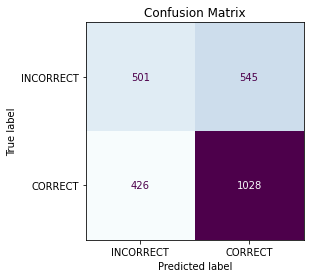

Model metrics:
{'accuracy': '61.16%', 'roc-auc': '64.13%', 'f1-score': '59.35%', 'fit_time': 0.07}


In [50]:
model_process(MultinomialNB(), 'Multinomial NB');

### Other models

In [51]:
# https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
# https://www.kaggle.com/dansbecker/xgboost

KNN


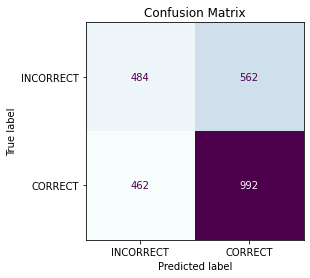

Model metrics:
{'accuracy': '59.04%', 'roc-auc': '59.99%', 'f1-score': '57.28%', 'fit_time': 0.01}


In [52]:
model_process(KNeighborsClassifier(), 'KNN');

Decision Tree


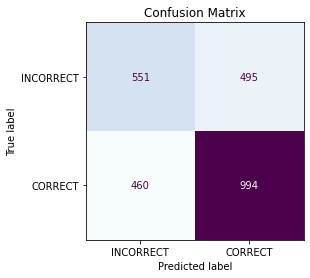

Model metrics:
{'accuracy': '61.80%', 'roc-auc': '61.77%', 'f1-score': '60.56%', 'fit_time': 1.61}


In [53]:
model_process(DecisionTreeClassifier(), 'Decision Tree');

In [54]:
# This takes a lot of time to execute ;(
# With the sample size of 10 thousand values it took more than 6 minutes to train
# Because of this we didn't continue using it
# from sklearn.svm import SVC
# model_process(SVC(probability=True), 'SVC');

Gaussian NB


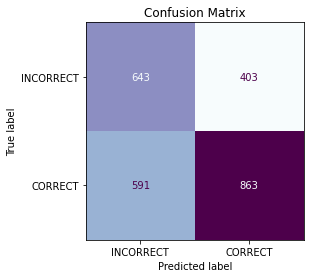

Model metrics:
{'accuracy': '60.24%', 'roc-auc': '64.89%', 'f1-score': '59.93%', 'fit_time': 0.23}


In [55]:
model_process(GaussianNB(), 'Gaussian NB');

[11:54:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost


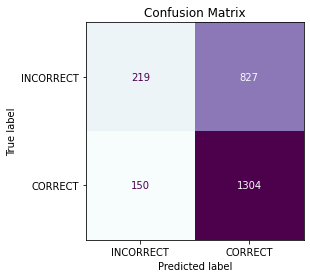

Model metrics:
{'accuracy': '60.92%', 'roc-auc': '62.98%', 'f1-score': '51.85%', 'fit_time': 5.99}


In [56]:
model_process(XGBClassifier(use_label_encoder=False), 'XGBoost');

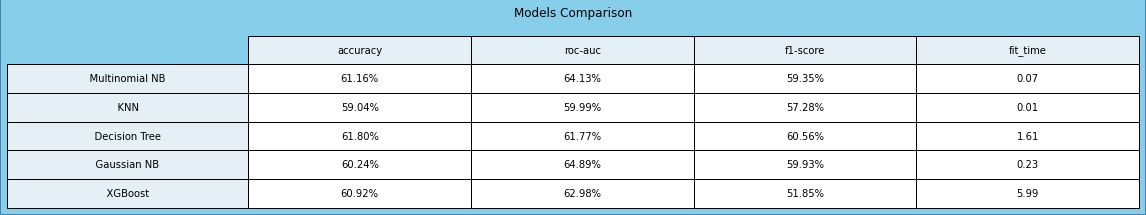

In [57]:
plot_table()

## Optimizing some hyperparameters

In [58]:
# https://aiinpractice.com/xgboost-hyperparameter-tuning-with-bayesian-optimization/
# https://github.com/fmfn/BayesianOptimization

In [59]:
def get_knn_defaults(param_grid={}):
    """ Get the default values of the model and parameters to be used while optimizing 
    the KNN model.
    
    Arguments:
        - param_grid (dict): a dictionary to be used instead of the default dictionary
            containing the name of the parameters and possible values
        
    Returns:
        - KNeighborsClassifier (KNeighborsClassifier): The instance of the machine learning
            classifier
        - param_grid (dict): The dictionary with the parameters used during the optimization
    """
    
    if param_grid == {}:
        param_grid = {
            'n_neighbors': list(range(1, 11)),
            'weights': ['uniform', 'distance']
        }
        
    return KNeighborsClassifier(), param_grid

In [60]:
def get_decision_tree_defaults(param_grid={}):
    """ Get the default values of the model and parameters to be used while optimizing 
    the Decision Tree model.
    
    Arguments:
        - param_grid (dict): a dictionary to be used instead of the default dictionary
            containing the name of the parameters and possible values
        
    Returns:
        - DecisionTreeClassifier (DecisionTreeClassifier): The instance of the machine learning
            classifier
        - param_grid (dict): The dictionary with the parameters used during the optimization
    """
    
    if param_grid == {}:
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [1, 10, 25, 50, 100, None],
            'min_samples_split': [2, 3, 5, 7, 10],
            'max_features': [None, 'sqrt', 'log2']
        }
        
    return DecisionTreeClassifier(), param_grid

In [61]:
def get_gaussian_nb_defaults(param_grid={}):
    """ Get the default values of the model and parameters to be used while optimizing 
    the Gaussian Naive Bayes model.
    
    Arguments:
        - param_grid (dict): a dictionary to be used instead of the default dictionary
            containing the name of the parameters and possible values
        
    Returns:
        - GaussianNB (GaussianNB): The instance of the machine learning classifier
        - param_grid (dict): The dictionary with the parameters used during the optimization
    """
    
    if param_grid == {}:
        param_grid = {
            'var_smoothing': np.logspace(0,-9, num=50)
        }
        
    return GaussianNB(), param_grid

In [62]:
def optimize_with_grid_search(model_name, param_grid={}, scoring='roc_auc', cv=2, n_jobs=8,
                             X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """ Helper function used to optimize some machine learning models using the GridSearchCV
    class and a dictionary with the optimization parameters.
    
    Arguments:
        - model_name (str): The name of the model to be used to get the right machine learning model,
            get the right parameters to be optimized and print the results
            The acceptables model names are: KNN, Decision Tree and Gaussian NB
        - param_grid (dict): The dictionary with the parameters to be used during the optimization 
        - scoring (str): The metric to be used to evaluate the models
            A complete list of the metrics could be found at: https://scikit-learn.org/stable/modules/model_evaluation.html
        - cv (int): Determine the number of folds of the cross validation
        - n_jobs (int): The number of jobs to run in parallel
            -1 means all processors available
        - X_train (pandas DataFrame): The input dataframe to be used to train the machine learning models
        - X_test (pandas DataFrame): The input dataframe to be used to test the machine learning models
        - y_train (pandas Series): The output values to be predicted by the machine learning models during training
        - y_test (pandas Series): The output values to be predicted by the machine learning models during testing
        - model_metrics (dict): The dictionary containing the metrics of the trained models
        - threshold (float): A value between 0 and 1 to indicate the threshold of the prediction probability
            of the true class
        
    Returns:
        - clf (Machine Learning classifier): The classifier with the best parameter values based on the inputs
    """
    
    if model_name == 'KNN':
        model, param_grid = get_knn_defaults(param_grid)
    elif model_name == 'Decision Tree':
        model, param_grid = get_decision_tree_defaults(param_grid)
    elif model_name == 'Gaussian NB':
        model, param_grid = get_gaussian_nb_defaults(param_grid)

    clf = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)
    
    # Had to do this because of the annoying warnings of the model
    if model_name == 'KNN':
        clf.fit(X_train.values, y_train)
    else:
        clf.fit(X_train, y_train)
    
    print('Best model:')
    print(clf.best_estimator_)
    print()
    
    model_process(clf.best_estimator_, model_name, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    
    return clf.best_estimator_

We used some global variables to pass parameters to the inner *xgb_param_optimize* function.

It is not the best practice but we used this way to make de code easier to understand.

In [63]:
xgb_cv = 2
xgb_scoring = 'roc_auc'

In [64]:
def xgb_param_optimize(**kwargs):
    """ The fuction used to optimize the XGBClassifier using the BayesianOptimization Class.
    
    Arguments:
        - kwargs (dict): The dictionary containing the parameters to be optimized and a range of values
            that could be used during the optimization process
        
    Returns:
        - score (float): The value of the metric used during the optimization process
    """
    
    if kwargs.get('max_depth'):
        kwargs['max_depth'] = int(kwargs.get('max_depth'))
    if kwargs.get('n_estimators'):
        kwargs['n_estimators'] = int(kwargs.get('n_estimators'))

    clf = XGBClassifier(use_label_encoder=False, seed=SEED, **kwargs)
    
    return np.mean(cross_val_score(clf, X_train, y_train, cv=xgb_cv, fit_params={'eval_metric': 'logloss'}, scoring=xgb_scoring))

In [65]:
def xgb_clf_optimize(pbounds, init_points=0, n_iter=1, X_train_local=X_train, y_train_local=y_train):
    """ Helper fuction used to instantiate and call functions of the BayesianOptimization Class for the
    XGBClassifier parameters optimization.
    
    Arguments:
        - pbounds (dict): The dictionary containing the parameters to be optimized and a range of values
            that could be used during the optimization process
        - init_points (int): How many steps of random exploration to be performed
        - n_iter (int): How many steps of bayesian optimization to be performed
        - X_train_local (pandas DataFrame): The input dataframe to be used to train the machine learning model
        - y_train_local (pandas DataFrame): The output values to be predicted by the machine learning model during training
        
    Returns:
        - params (dict): The best parameters to be used with the XGBClassifier
    """
    
    global X_train
    global y_train
    
    bkp_X_train = X_train.copy()
    bkp_y_train = y_train.copy()
    
    X_train = X_train_local
    y_train = y_train_local
    
    optimizer = BayesianOptimization(
        f=xgb_param_optimize,
        pbounds=pbounds,
        random_state=SEED,
    )
    
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter,
    )
    
    X_train = bkp_X_train
    y_train = y_train
    
    return optimizer.max

In [66]:
def optimize_with_bayesian(model_name, pbounds={}, scoring='roc_auc', cv=2, init_points=0, n_iter=1,
                          X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """ Helper function used to optimize the XGBClassifier model and print the performance of the model.
    
    Arguments:
        - model_name (str): The name of the model to be used to print the results of the optimization
        - pbounds (dict): The dictionary containing the parameters to be optimized and a range of values
            that could be used during the optimization process. If no value is passed, the default values
            are going to be used during optimization            
        - scoring (str): The metric to be used to evaluate the model
            A complete list of the metrics could be found at: https://scikit-learn.org/stable/modules/model_evaluation.html
        - cv (int): Determine the number of folds of the cross validation
        - init_points (int): How many steps of random exploration to be performed
        - n_iter (int): How many steps of bayesian optimization to be performed
        - X_train (pandas DataFrame): The input dataframe to be used to train the machine learning models
        - X_test (pandas DataFrame): The input dataframe to be used to test the machine learning models
        - y_train (pandas Series): The output values to be predicted by the machine learning models during training
        - y_test (pandas Series): The output values to be predicted by the machine learning models during testing
        
    Returns:
        - clf (Machine Learning classifier): The classifier with the best parameter values based on the inputs
    """
    
    if pbounds == {}:
        pbounds = {
            'learning_rate': (0.01, 1.0),
        #     'n_estimators': (100, 1000),
        #     'max_depth': (3,10),
        #     'gamma': (0, 5),
        #     'min_child_weight': (1, 10),
        #     'colsample_bytree': (0.5, 1),
        #     'reg_alpha': (0, 10),
        #     'reg_lambda': (0, 10)
        }
    
    global xgb_cv
    global xgb_scoring
    xgb_cv = cv
    xgb_scoring = scoring
        
    best_params = xgb_clf_optimize(pbounds, init_points, n_iter, X_train_local=X_train, y_train_local=y_train)
    params = best_params['params']
    
    clf = XGBClassifier(use_label_encoder=False, seed=SEED, **params)
    
    print('Best model:')
    print(clf)
    print()
    
    model_process(clf, model_name, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    
    return clf

In [67]:
def get_best_model(model_name, params={}, scoring='roc_auc', cv=2, init_points=0, n_iter=1, n_jobs=8,
                  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """ Helper function used to optimize the parameters of the machine learning models.
    
    Arguments:
        - model_name (str): The name of the model to be used to get the right machine learning model,
            get the right parameters to be optimized and print the results
            The acceptables model names are: KNN, Decision Tree, Gaussian NB and XGBoost
        - params (dict): The dictionary with the parameters to be used during the optimization. 
            If no value is passed, the default values are going to be used during optimization.
            In case of the XGBoost model, the values of the parameters have to be a range of
            possible values
        - scoring (str): The metric to be used to evaluate the model
            A complete list of the metrics could be found at: https://scikit-learn.org/stable/modules/model_evaluation.html
        - cv (int): Determine the number of folds of the cross validation
        - init_points (int): How many steps of random exploration to be performed (Only to XGBoost)
        - n_iter (int): How many steps of bayesian optimization to be performed (Only to XGBoost)
        - n_jobs (int): The number of jobs to run in parallel. -1 means all processors available
        - X_train (pandas DataFrame): The input dataframe to be used to train the machine learning models
        - X_test (pandas DataFrame): The input dataframe to be used to test the machine learning models
        - y_train (pandas Series): The output values to be predicted by the machine learning models during training
        - y_test (pandas Series): The output values to be predicted by the machine learning models during testing
        
    Returns:
        - clf (Machine Learning classifier): The classifier with the best parameter values based on the inputs
    """
    
    GRID_SEARCH_MODELS = {'KNN', 'Decision Tree', 'Gaussian NB'}
    AVAILABLE_MODELS = GRID_SEARCH_MODELS | {'XGBoost'}
    
    if model_name not in AVAILABLE_MODELS:
        raise ValueError("model_name: Must be one of the following values %r." % AVAILABLE_MODELS)
        
    if model_name in GRID_SEARCH_MODELS:
        return optimize_with_grid_search(model_name, params, scoring=scoring, cv=cv, n_jobs=n_jobs,
                                        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    else:
        return optimize_with_bayesian(model_name, params, scoring=scoring, cv=cv, init_points=init_points, n_iter=n_iter,
                              X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

**KNN**

In [68]:
# knn_best = get_best_model('KNN')

**Decision Tree**

In [69]:
# dtc_best = get_best_model('Decision Tree')

**Gaussian NB**

In [70]:
# gaussian_nb_best = get_best_model('Gaussian NB')

**XGBoost**

In [71]:
# xgb_best = get_best_model('XGBoost')

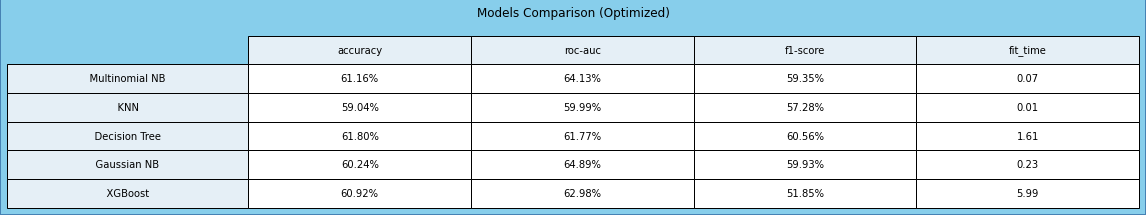

In [72]:
plot_table(title='Models Comparison (Optimized)')

# Enhancing the dataset with new ideas

The dataset has some few columns that could be used directly to our analysis, so at this part we tried to generate new data to be used by the machine learning algorithms.

We tried to create data to specify the difficulty level of each problem/step values. We also created some metric to determine what's the proficiency of the students with math exercises.

The defined metrics were very simple, only using the differences betwenn correct and incorrect answers.

Because the values of the new columns were created based on the outputs' values (our y) id could cause some bias to the model.

**Difficulty Level**

In [73]:
df_difficulty = df_cleaned[df_cleaned['Outcome'].isin(['CORRECT', 'INCORRECT'])]

In [74]:
df_difficulty = df_difficulty.groupby(['Problem Name', 'Step Name', 'Outcome']).count()
df_difficulty = df_difficulty.iloc[:, 0].unstack().fillna(0)
df_difficulty['Difficulty Calc'] = (df_difficulty['CORRECT'] - df_difficulty['INCORRECT'])/ (df_difficulty['CORRECT'] + df_difficulty['INCORRECT'])

In [75]:
df_difficulty['Difficulty Calc'].describe()

count    3669.000000
mean        0.275100
std         0.534535
min        -1.000000
25%        -0.061224
50%         0.247706
75%         0.739130
max         1.000000
Name: Difficulty Calc, dtype: float64

In [76]:
def calculate_difficulty(x):
    """ Apply some conditions to determine the difficulty of a question based on the value
    of the Difficulty Calc column.
    
    Arguments:
        - x (float): The value of the column to be analyzed
        
    Returns:
        - difficulty (str): The string that represents de difficulty of the question
    """
    
    if x <= df_difficulty['Difficulty Calc'].quantile(.25):
        return 'Hard'
    elif x <= df_difficulty['Difficulty Calc'].quantile(.75):
        return 'Normal'
    else:
        return 'Easy'

In [77]:
df_difficulty['Difficulty Level'] = df_difficulty['Difficulty Calc'].apply(calculate_difficulty)

In [78]:
df_difficulty.head()

Outcome                                                          CORRECT  \
Problem Name Step Name                                                     
7            Step0:7:Figure ABCD is translated so that the i...     23.0   
             Step1:5678:First let's find how point A is rela...     25.0   
             Step2:5681:How far up is A' from A? TextFieldQu...     25.0   
             Step3:5680:Point B is related to the image of p...     23.0   
             Step4:5679:What is the y-coordinate of the imag...     22.0   

Outcome                                                          INCORRECT  \
Problem Name Step Name                                                       
7            Step0:7:Figure ABCD is translated so that the i...       26.0   
             Step1:5678:First let's find how point A is rela...       26.0   
             Step2:5681:How far up is A' from A? TextFieldQu...        7.0   
             Step3:5680:Point B is related to the image of p...       44.0   
             Step4:5679:What is the y-coordinate of the imag...       12.0   

Outcome                                                          Difficulty Calc  \
Problem Name Step Name                                                             
7            Step0:7:Figure ABCD is translated so that the i...        -0.061224   
             Step1:5678:First let's find how point A is rela...        -0.019608   
             Step2:5681:How far up is A' from A? TextFieldQu...         0.562500   
             Step3:5680:Point B is related to the image of p...        -0.313433   
             Step4:5679:What is the y-coordinate of the imag...         0.294118   

Outcome                                                         Difficulty Level  
Problem Name Step Name                                                            
7            Step0:7:Figure ABCD is translated so that the i...             Hard  
             Step1:5678:First let's find how point A is rela...           Normal  
             Step2:5681:How far up is A' from A? TextFieldQu...           Normal  
             Step3:5680:Point B is related to the image of p...             Hard  
             Step4:5679:What is the y-coordinate of the imag...           Normal

In [79]:
# Only for tests
# df_cleaned = df_cleaned.drop(columns='Difficulty Level')

In [80]:
df_cleaned = df_cleaned.join(df_difficulty['Difficulty Level'], on=['Problem Name', 'Step Name'])

In [81]:
# Determining the Normal difficulty level where we didn't have data to determine
# This is probably because there is no data with the response Outcomes or some missing data in the grouping columns
df_cleaned['Difficulty Level'] = df_cleaned['Difficulty Level'].fillna('Normal')

**Math Proficiency**

In [82]:
df_proficiency = df_cleaned[df_cleaned['Outcome'].isin(['CORRECT', 'INCORRECT'])]

In [83]:
df_proficiency = df_proficiency.groupby(['Anon Student Id', 'Outcome']).count()
df_proficiency = df_proficiency.iloc[:, 0].unstack().fillna(0)
df_proficiency['Proficiency Calc'] = (df_proficiency['CORRECT'] - df_proficiency['INCORRECT'])/ (df_proficiency['CORRECT'] + df_proficiency['INCORRECT'])

In [84]:
df_proficiency['Proficiency Calc'].describe()

count    327.000000
mean       0.180068
std        0.278712
min       -0.698113
25%        0.000000
50%        0.156250
75%        0.368629
max        1.000000
Name: Proficiency Calc, dtype: float64

In [85]:
def calculate_proficiency(x):
    """ Apply some conditions to determine the proficiency of the student in math
    based on the value of the Proficiency Calc column.
    
    Arguments:
        - x (float): The value of the column to be analyzed
        
    Returns:
        - difficulty (str): The string that represents de proficiency of the student
    """
    
    if x <= df_proficiency['Proficiency Calc'].quantile(.25):
        return 'Low'
    elif x <= df_proficiency['Proficiency Calc'].quantile(.75):
        return 'Normal'
    else:
        return 'High'

In [86]:
df_proficiency['Proficiency Level'] = df_proficiency['Proficiency Calc'].apply(calculate_proficiency)

In [87]:
df_proficiency.head()

Outcome,CORRECT,INCORRECT,Proficiency Calc,Proficiency Level
Anon Student Id,,,,
Stu_000271be877ea1e7bf4f038c96cee5f9,44.0,9.0,0.660377,High
Stu_000327eb014359d69e940f15aef1b53d,221.0,89.0,0.425806,High
Stu_000da9f6798e6b7c5a1b01b5fcda8b78,325.0,256.0,0.118761,Normal
Stu_000faad08edf838f1e1fa87bf2aa4fed,347.0,160.0,0.368836,High
Stu_0010dcb33a30eaac9a317199930b40f1,38.0,11.0,0.551020,High


In [88]:
# Only for tests
# df_cleaned = df_cleaned.drop(columns='Proficiency Level')

In [89]:
df_cleaned = df_cleaned.join(df_proficiency['Proficiency Level'], on=['Anon Student Id'])

In [90]:
# Determining the Normal proficiency level where we didn't have data to determine
# This is probably because there is no data with the response Outcomes or some missing data in the grouping columns
df_cleaned['Proficiency Level'] = df_cleaned['Proficiency Level'].fillna('Normal')

## Preparing the new dataset

In [91]:
ml_columns = ['Problem Name', 'Step Name', 'Attempt At Step', 'Outcome', 'Last Help Level', 'Difficulty Level', 'Proficiency Level']

df_ml, df_filtered = generate_samples(ml_columns, df_cleaned=df_cleaned)
df_ml = create_step_dummies(df_ml)
df_ml = replace_dtypes(df_ml)

In [92]:
difficulty_dummies = pd.get_dummies(df_ml['Difficulty Level'], prefix='Difficulty')
proficiency_dummies = pd.get_dummies(df_ml['Proficiency Level'], prefix='Proficiency')

df_ml = pd.concat([df_ml, difficulty_dummies, proficiency_dummies], axis=1)
df_ml = df_ml.drop(['Difficulty Level', 'Proficiency Level'], axis=1)

In [93]:
df_ml.head()

,Problem Name,Attempt At Step,Outcome,Last Help Level,Step0:13666,Step1:9189,Step4:5718,Step2:512,Step0:1291,Step0:8337,...,Step3:7425,Step1:14929,Step3:22646,Step0:8192,Difficulty_Easy,Difficulty_Hard,Difficulty_Normal,Proficiency_High,Proficiency_Low,Proficiency_Normal
0,13666,5,1,4,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,5790,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,106,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,510,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1291,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [94]:
X_train, X_test, y_train, y_test = train_test_create(df_ml)

## Testing the models with the new data

In [95]:
# model_process(MultinomialNB(), 'Multinomial NB', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test);

In [96]:
# knn_best = get_best_model('KNN', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [97]:
# dtc_best = get_best_model('Decision Tree', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Best model:
GaussianNB(var_smoothing=1.5264179671752304e-09)

Gaussian NB


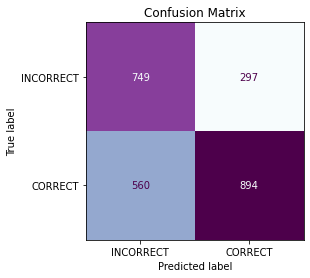

Model metrics:
{'accuracy': '65.72%', 'roc-auc': '73.28%', 'f1-score': '65.60%', 'fit_time': 0.23}


In [98]:
gaussian_nb_best = get_best_model('Gaussian NB', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [99]:
# xgb_best = get_best_model('XGBoost', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

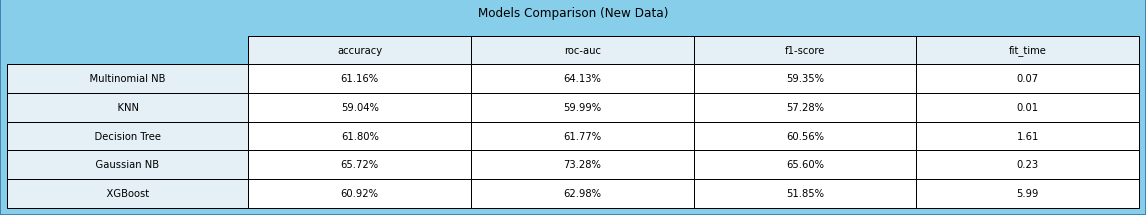

In [100]:
plot_table(title='Models Comparison (New Data)')

In [101]:
### TODO optimize threshold
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [102]:
# getting only the best model from above

In [103]:
y_pred = gaussian_nb_best.predict_proba(X_test)

# Keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]

# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Get the best threshold based on Youden's J statistic
J = tpr - fpr
idx = np.argmax(J)
best_threshold = thresholds[idx]
print('Best threshold: {:.4f}'.format(best_threshold))

Best threshold: 0.5027


Gaussian NB


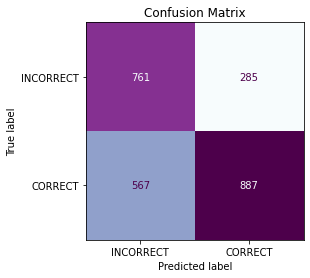

Model metrics:
{'accuracy': '65.92%', 'roc-auc': '73.28%', 'f1-score': '65.83%', 'fit_time': 0.24}


In [104]:
model_process(gaussian_nb_best, 'Gaussian NB', threshold=best_threshold, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test);